In [1]:
#Just to copy the dataset from the input to the output in kaggle
!cp -r /kaggle/input/'dataset-unet-olives' ./datasets

In [1]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()


In [ ]:
import os
from pathlib import Path
from tqdm import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import gc

# Clear memory at start
gc.collect()
torch.cuda.empty_cache()

# ===========================
#  U-Net model (PyTorch)
# ===========================
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, base_filters=64):
        super().__init__()
        f = base_filters
        self.inc = DoubleConv(in_channels, f)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(f, f*2))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(f*2, f*4))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(f*4, f*8))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(f*8, f*8))
        self.up1 = nn.ConvTranspose2d(f*8, f*8, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(f*16, f*4)
        self.up2 = nn.ConvTranspose2d(f*4, f*4, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(f*8, f*2)
        self.up3 = nn.ConvTranspose2d(f*2, f*2, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(f*4, f)
        self.up4 = nn.ConvTranspose2d(f, f, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(f*2, f)
        self.outc = nn.Conv2d(f, out_channels, kernel_size=1)
    
    def forward(self, x):
        x1 = self.inc(x)        # 1
        x2 = self.down1(x1)     # 1/2
        x3 = self.down2(x2)     # 1/4
        x4 = self.down3(x3)     # 1/8
        x5 = self.down4(x4)     # 1/16
        x = self.up1(x5)
        x = torch.cat([x, x4], dim=1)
        x = self.conv1(x)
        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.conv2(x)
        x = self.up3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.conv3(x)
        x = self.up4(x)
        x = torch.cat([x, x1], dim=1)
        x = self.conv4(x)
        x = self.outc(x)
        return x

# ===========================
# Dataset (Fixed)
# ===========================
class SegDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transforms=None, img_exts=(".png",".jpg",".tif",".jpeg")):
        self.images_dir = Path(images_dir)
        self.masks_dir = Path(masks_dir)
        self.images = sorted([p for p in self.images_dir.iterdir() if p.suffix.lower() in img_exts])
        self.transforms = transforms
        
    def __len__(self): 
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        # Try multiple mask naming conventions
        mask_candidates = [
            self.masks_dir / (img_path.stem + "_mask.png"),
            self.masks_dir / (img_path.stem + ".png"),
            self.masks_dir / img_path.name,
        ]
        
        mask_path = None
        for candidate in mask_candidates:
            if candidate.exists():
                mask_path = candidate
                break
        
        if mask_path is None:
            raise FileNotFoundError(f"No mask found for {img_path.name}")
        
        img = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))
        
        # Normalize mask to 0/1
        if mask.max() > 1:
            mask = (mask > 127).astype(np.uint8)
        
        # Apply transforms
        if self.transforms:
            augmented = self.transforms(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]
        else:
            # Default: just convert to tensor
            transform = A.Compose([
                A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
                ToTensorV2()
            ])
            augmented = transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]
        
        # Ensure mask is (H, W) and long type
        if mask.ndim == 3:
            mask = mask.squeeze(0)
        mask = mask.long()
        
        return img, mask

# ===========================
# Metrics (Improved)
# ===========================

from IoU_score import iou_score, dice_score

# ===========================
# Utility: get transforms
# ===========================
from get_transform import get_transforms

# ===========================
# Training routine (Improved)
# ===========================
from Trainer_protocol import train_model
# ===========================
# Inference helper + visualize
# ===========================
from Inference_and_visualize import predict_and_visualize
    
    

# ===========================
# Plot training history
# ===========================
from plot_training_hist import plot_history

# ===========================
# Example usage
# ===========================
if __name__ == "__main__":
    # Edit these paths to your dataset
    train_images = r"F:\POST GRADUATE CRASTE LF\SECOND YEAR\Machine Learning\UNET\Dataset_unet\images\train"
    train_masks  = r"F:\POST GRADUATE CRASTE LF\SECOND YEAR\Machine Learning\UNET\Dataset_unet\i_masks"
    val_images   = r"F:\POST GRADUATE CRASTE LF\SECOND YEAR\Machine Learning\UNET\Dataset_unet\images\val"
    val_masks    = r"F:\POST GRADUATE CRASTE LF\SECOND YEAR\Machine Learning\UNET\Dataset_unet\v_masks"
    
    # Parameters
    NUM_CLASSES = 2
    IMG_SIZE = 640
    EPOCHS = 50
    BATCH = 2
    LR = 1e-4
    DEVICE = None  # Auto-detect
    
    # Train
    # model, history = train_model(
    #     train_images, train_masks,
    #     val_images, val_masks,
    #     num_classes=NUM_CLASSES,
    #     img_size=IMG_SIZE,
    #     epochs=EPOCHS,
    #     batch_size=BATCH,
    #     lr=LR,
    #     device=DEVICE,
    #     model_save_path="unet_best.pth"
    # )
    
    # # Plot results
    # plot_history(history)
    
    

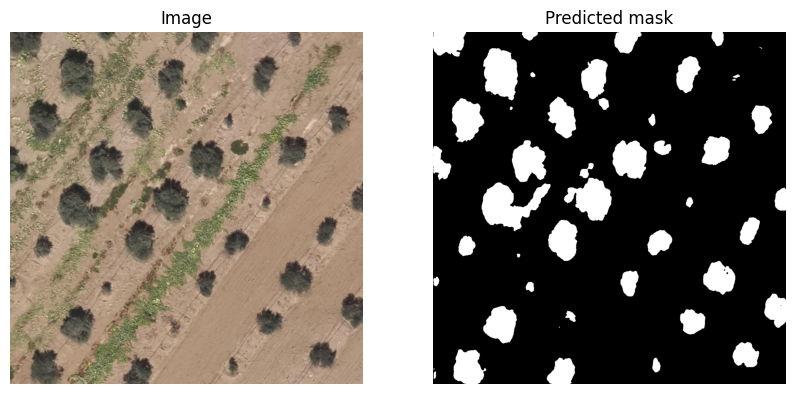

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(1024, 1024), dtype=uint8)

In [4]:

# Test on a sample image
sample_image = r"F:\POST GRADUATE CRASTE LF\SECOND YEAR\Machine Learning\UNET\Dataset_unet\images\train\tile_y00006_x00015_png.rf.3ad86fd57d4cffe67e0a97e53c9fe4d9.jpg"
predict_and_visualize(r"F:\POST GRADUATE CRASTE LF\SECOND YEAR\Machine Learning\UNET\unet_best.pth", sample_image)

In [9]:
model_path = "unet_best.pth"

In [16]:
import os
import gc
import numpy as np
from pathlib import Path
import torch
import skimage
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import rasterio
from rasterio.windows import Window
import geopandas as gpd
from shapely.geometry import Polygon
from tqdm import tqdm
import warnings
from PIL import Image  # ← ADD THIS IMPORT
warnings.filterwarnings('ignore')

# ===========================
# U-Net Model Definition (Copy from your training script)
# ===========================
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, base_filters=64):
        super().__init__()
        f = base_filters
        self.inc = DoubleConv(in_channels, f)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(f, f*2))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(f*2, f*4))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(f*4, f*8))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(f*8, f*8))
        self.up1 = nn.ConvTranspose2d(f*8, f*8, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(f*16, f*4)
        self.up2 = nn.ConvTranspose2d(f*4, f*4, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(f*8, f*2)
        self.up3 = nn.ConvTranspose2d(f*2, f*2, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(f*4, f)
        self.up4 = nn.ConvTranspose2d(f, f, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(f*2, f)
        self.outc = nn.Conv2d(f, out_channels, kernel_size=1)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5)
        x = torch.cat([x, x4], dim=1)
        x = self.conv1(x)
        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.conv2(x)
        x = self.up3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.conv3(x)
        x = self.up4(x)
        x = torch.cat([x, x1], dim=1)
        x = self.conv4(x)
        x = self.outc(x)
        return x

# ===========================
# Orthomosaic Tiling Dataset
# ===========================
class OrthomosaicTiler(Dataset):
    def __init__(self, ortho_path, tile_size=256, stride=None, transform=None):
        self.ortho_path = ortho_path
        self.tile_size = tile_size
        self.stride = stride or tile_size // 2
        self.transform = transform
        
        with rasterio.open(ortho_path) as src:
            self.width = src.width
            self.height = src.height
            self.crs = src.crs
            self.transform_affine = src.transform
            
        self.tile_positions = []
        for y in range(0, self.height, self.stride):
            for x in range(0, self.width, self.stride):
                if x + tile_size <= self.width and y + tile_size <= self.height:
                    self.tile_positions.append((x, y))
    
    def __len__(self):
        return len(self.tile_positions)
    
    def __getitem__(self, idx):
        x, y = self.tile_positions[idx]
        
        with rasterio.open(self.ortho_path) as src:
            window = Window(x, y, self.tile_size, self.tile_size)
            tile = src.read(window=window)
            
        if tile.shape[0] == 1:
            tile = np.stack([tile[0]] * 3)
        elif tile.shape[0] == 4:
            tile = tile[:3]
        
        tile = np.transpose(tile, (1, 2, 0))
        if tile.dtype != np.uint8:
            tile = (tile / tile.max() * 255).astype(np.uint8)
        
        if self.transform:
            augmented = self.transform(image=tile)
            tile = augmented["image"]
        else:
            transform = A.Compose([
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2()
            ])
            augmented = transform(image=tile)
            tile = augmented["image"]
        
        return tile, x, y

# ===========================
# Polygon Extraction
# ===========================
def mask_to_polygons(mask, transform, min_area=10.0):
    """Convert binary mask to polygons with georeferencing"""
    from skimage import measure
    
    polygons = []
    contours = measure.find_contours(mask, 0.5)
    
    for contour in contours:
        world_coords = []
        for y, x in contour:
            world_x, world_y = transform * (x, y)
            world_coords.append((world_x, world_y))
        
        if len(world_coords) >= 3:
            polygon = Polygon(world_coords)
            if polygon.area >= min_area:
                polygons.append(polygon)
    
    return polygons

# ===========================
# Main Inference Pipeline
# ===========================
def process_orthomosaic_to_gpkg(
    model_path,
    ortho_path,
    output_gpkg,
    tile_size=640,
    stride=320,
    batch_size=4,
    threshold=0.3,  # Lower threshold to catch more predictions
    min_polygon_area=5.0,  # Much smaller area threshold
    device=None
):
    """
    Process orthomosaic with trained U-Net and export polygons to GPKG
    """
    
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Auto-detect num_classes from model
    ckpt = torch.load(model_path, map_location=device)
    outc_weight_shape = ckpt["model_state"]["outc.weight"].shape
    num_classes = outc_weight_shape[0]
    print(f"Detected model with {num_classes} output classes")
    
    # Load model
    model = UNet(in_channels=3, out_channels=num_classes).to(device)
    model.load_state_dict(ckpt["model_state"])
    model.eval()
    print("Model loaded successfully")
    
    # Prepare dataset
    transform = A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    
    dataset = OrthomosaicTiler(
        ortho_path, 
        tile_size=tile_size, 
        stride=stride, 
        transform=transform
    )
    
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=0,
        pin_memory=True
    )
    
    print(f"Processing {len(dataset)} tiles from orthomosaic")
    
    # Get CRS and transform from orthomosaic
    with rasterio.open(ortho_path) as src:
        crs = src.crs
        base_transform = src.transform
    
    # Process tiles
    all_polygons = []
    total_pixels = 0
    positive_pixels = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Processing tiles"):
            tiles, x_coords, y_coords = batch
            tiles = tiles.to(device, non_blocking=True)
            
            outputs = model(tiles)
            
            # DEBUG: Print output statistics
            print(f"Output range: [{outputs.min().item():.3f}, {outputs.max().item():.3f}]")
            
            if num_classes == 2:
                # Use softmax and take class 1 (foreground)
                probs = torch.softmax(outputs, dim=1)
                class1_probs = probs[:, 1]  # Foreground probabilities
                preds = (class1_probs > threshold).cpu().numpy()
                
                # DEBUG: Print probability statistics
                print(f"Class 1 prob range: [{class1_probs.min().item():.3f}, {class1_probs.max().item():.3f}]")
                print(f"Positive pixels in batch: {np.sum(preds)} / {preds.size}")
                
            elif num_classes == 1:
                probs = torch.sigmoid(outputs)
                preds = (probs > threshold).squeeze(1).cpu().numpy()
            else:
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
            
            for i, (pred, x, y) in enumerate(zip(preds, x_coords, y_coords)):
                total_pixels += pred.size
                positive_pixels += np.sum(pred)
                
                tile_transform = rasterio.windows.transform(
                    Window(x.item(), y.item(), tile_size, tile_size), 
                    base_transform
                )
                
                polygons = mask_to_polygons(
                    pred, 
                    tile_transform, 
                    min_area=min_polygon_area
                )
                all_polygons.extend(polygons)
                
                # DEBUG: Save first tile prediction as image to check
                if i == 0 and len(polygons) > 0:
                    debug_mask = (pred * 255).astype(np.uint8)
                    Image.fromarray(debug_mask).save("debug_first_tile.png")
                    print(f"Saved debug image with {len(polygons)} polygons")
    
    print(f"Pixel statistics: {positive_pixels}/{total_pixels} positive pixels ({positive_pixels/total_pixels*100:.2f}%)")
    print(f"Extracted {len(all_polygons)} raw polygons")
    
    # Create and save GeoDataFrame
    if all_polygons:
        gdf = gpd.GeoDataFrame(
            {'geometry': all_polygons},
            crs=crs
        )
        
        print(f"Before validity check: {len(gdf)} polygons")
        gdf = gdf[gdf.is_valid]
        print(f"After validity check: {len(gdf)} polygons")
        
        if len(gdf) > 0:
            # Dissolve overlapping polygons
            gdf = gdf.dissolve()
            gdf = gdf.explode(index_parts=True).reset_index(drop=True)
            print(f"After dissolve/explode: {len(gdf)} polygons")
            
            # Calculate areas and filter
            gdf['area'] = gdf.geometry.area
            print(f"Area range: [{gdf['area'].min():.2f}, {gdf['area'].max():.2f}]")
            
            gdf = gdf[gdf['area'] >= min_polygon_area]
            print(f"After area filter: {len(gdf)} polygons")
            
            if len(gdf) > 0:
                gdf.to_file(output_gpkg, driver='GPKG')
                print(f"Saved {len(gdf)} polygons to {output_gpkg}")
            else:
                print("No polygons left after area filtering")
        else:
            print("No valid polygons found")
    else:
        print("No polygons extracted from any tiles")
    
    # Cleanup
    del model
    torch.cuda.empty_cache()
    gc.collect()

# Also add this debug function to check the model output
def debug_model_predictions(model_path, image_path, device=None):
    """Debug function to check model predictions on a single image"""
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load model
    ckpt = torch.load(model_path, map_location=device)
    num_classes = ckpt["model_state"]["outc.weight"].shape[0]
    model = UNet(in_channels=3, out_channels=num_classes).to(device)
    model.load_state_dict(ckpt["model_state"])
    model.eval()
    
    # Load and process image
    img = np.array(Image.open(image_path).convert("RGB"))
    transform = A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    augmented = transform(image=img)
    inp = augmented["image"].unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(inp)
        print(f"Raw outputs shape: {outputs.shape}")
        print(f"Raw outputs range: [{outputs.min().item():.3f}, {outputs.max().item():.3f}]")
        
        if num_classes == 2:
            probs = torch.softmax(outputs, dim=1)
            print(f"Class 0 probs: [{probs[0,0].min().item():.3f}, {probs[0,0].max().item():.3f}]")
            print(f"Class 1 probs: [{probs[0,1].min().item():.3f}, {probs[0,1].max().item():.3f}]")
            
            for threshold in [0.1, 0.3, 0.5, 0.7]:
                pred = (probs[0, 1] > threshold).cpu().numpy()
                print(f"Threshold {threshold}: {np.sum(pred)}/{pred.size} positive pixels ({np.sum(pred)/pred.size*100:.1f}%)")

# Run debug first
if __name__ == "__main__":
    # First debug with a sample image
    sample_image = r"F:\POST GRADUATE CRASTE LF\SECOND YEAR\Machine Learning\UNET\Dataset_unet\images\train\tile_y00006_x00015_png.rf.3ad86fd57d4cffe67e0a97e53c9fe4d9.jpg"
    debug_model_predictions(r"F:\POST GRADUATE CRASTE LF\SECOND YEAR\Machine Learning\UNET\unet_best.pth", sample_image)
    
    # Then process orthomosaic
    process_orthomosaic_to_gpkg(
        model_path=r"F:\POST GRADUATE CRASTE LF\SECOND YEAR\Machine Learning\UNET\unet_best.pth",
        ortho_path=r"Orthomosaic.tif",
        output_gpkg=r"F:\POST GRADUATE CRASTE LF\SECOND YEAR\Machine Learning\UNET\buildings.gpkg",
        tile_size=640,
        stride=320,
        batch_size=2,
        threshold=0.3,  # Start with lower threshold
        min_polygon_area=0.2  # Smaller area
    )

Raw outputs shape: torch.Size([1, 2, 1024, 1024])
Raw outputs range: [-2.921, 16.868]
Class 0 probs: [0.048, 1.000]
Class 1 probs: [0.000, 0.952]
Threshold 0.1: 998758/1048576 positive pixels (95.2%)
Threshold 0.3: 971565/1048576 positive pixels (92.7%)
Threshold 0.5: 889616/1048576 positive pixels (84.8%)
Threshold 0.7: 850519/1048576 positive pixels (81.1%)
Using device: cpu
Detected model with 2 output classes
Model loaded successfully
Processing 552 tiles from orthomosaic


Processing tiles:   0%|          | 1/276 [00:04<22:05,  4.82s/it]

Output range: [-3.074, 9.508]
Class 1 prob range: [0.000, 0.965]
Positive pixels in batch: 793710 / 819200
Saved debug image with 5 polygons


Processing tiles:   1%|          | 2/276 [00:09<21:02,  4.61s/it]

Output range: [-2.579, 9.759]
Class 1 prob range: [0.000, 0.950]
Positive pixels in batch: 798342 / 819200
Saved debug image with 1 polygons


Processing tiles:   1%|          | 3/276 [00:14<21:12,  4.66s/it]

Output range: [-2.684, 9.759]
Class 1 prob range: [0.000, 0.956]
Positive pixels in batch: 784615 / 819200
Saved debug image with 6 polygons


Processing tiles:   1%|▏         | 4/276 [00:18<21:40,  4.78s/it]

Output range: [-2.654, 1.137]
Class 1 prob range: [0.273, 0.953]
Positive pixels in batch: 819163 / 819200


Processing tiles:   2%|▏         | 5/276 [00:24<22:24,  4.96s/it]

Output range: [-2.779, 1.123]
Class 1 prob range: [0.291, 0.957]
Positive pixels in batch: 819197 / 819200


Processing tiles:   2%|▏         | 6/276 [00:28<21:38,  4.81s/it]

Output range: [-2.797, 3.887]
Class 1 prob range: [0.013, 0.959]
Positive pixels in batch: 812823 / 819200
Saved debug image with 1 polygons


Processing tiles:   3%|▎         | 7/276 [00:33<21:13,  4.73s/it]

Output range: [-2.776, 5.410]
Class 1 prob range: [0.003, 0.959]
Positive pixels in batch: 786361 / 819200
Saved debug image with 3 polygons


Processing tiles:   3%|▎         | 8/276 [00:37<20:50,  4.67s/it]

Output range: [-2.707, 9.458]
Class 1 prob range: [0.000, 0.956]
Positive pixels in batch: 763270 / 819200
Saved debug image with 1 polygons


Processing tiles:   3%|▎         | 9/276 [00:42<20:14,  4.55s/it]

Output range: [-2.887, 14.417]
Class 1 prob range: [0.000, 0.959]
Positive pixels in batch: 785689 / 819200
Saved debug image with 1 polygons


Processing tiles:   4%|▎         | 10/276 [00:46<19:53,  4.49s/it]

Output range: [-2.877, 14.245]
Class 1 prob range: [0.000, 0.959]
Positive pixels in batch: 812554 / 819200


Processing tiles:   4%|▍         | 11/276 [00:51<20:01,  4.54s/it]

Output range: [-2.877, 17.027]
Class 1 prob range: [0.000, 0.963]
Positive pixels in batch: 797050 / 819200
Saved debug image with 4 polygons


Processing tiles:   4%|▍         | 12/276 [00:55<19:34,  4.45s/it]

Output range: [-2.768, 17.028]
Class 1 prob range: [0.000, 0.960]
Positive pixels in batch: 801375 / 819200
Saved debug image with 3 polygons


Processing tiles:   5%|▍         | 13/276 [01:00<19:46,  4.51s/it]

Output range: [-3.027, 13.091]
Class 1 prob range: [0.000, 0.962]
Positive pixels in batch: 782587 / 819200
Saved debug image with 3 polygons


Processing tiles:   5%|▌         | 14/276 [01:05<20:26,  4.68s/it]

Output range: [-2.579, 13.091]
Class 1 prob range: [0.000, 0.950]
Positive pixels in batch: 785066 / 819200
Saved debug image with 3 polygons


Processing tiles:   5%|▌         | 15/276 [01:10<20:59,  4.83s/it]

Output range: [-2.579, 5.610]
Class 1 prob range: [0.003, 0.950]
Positive pixels in batch: 813745 / 819200
Saved debug image with 2 polygons


Processing tiles:   6%|▌         | 16/276 [01:15<21:49,  5.04s/it]

Output range: [-2.551, 1.137]
Class 1 prob range: [0.273, 0.947]
Positive pixels in batch: 819163 / 819200


Processing tiles:   6%|▌         | 17/276 [01:21<22:25,  5.19s/it]

Output range: [-2.779, 1.236]
Class 1 prob range: [0.286, 0.957]
Positive pixels in batch: 819190 / 819200


Processing tiles:   7%|▋         | 18/276 [01:26<22:00,  5.12s/it]

Output range: [-2.779, 1.137]
Class 1 prob range: [0.305, 0.957]
Positive pixels in batch: 819200 / 819200


Processing tiles:   7%|▋         | 19/276 [01:31<21:50,  5.10s/it]

Output range: [-2.754, 4.314]
Class 1 prob range: [0.008, 0.957]
Positive pixels in batch: 817123 / 819200


Processing tiles:   7%|▋         | 20/276 [01:36<21:37,  5.07s/it]

Output range: [-2.733, 9.458]
Class 1 prob range: [0.000, 0.957]
Positive pixels in batch: 772706 / 819200
Saved debug image with 1 polygons


Processing tiles:   8%|▊         | 21/276 [01:41<22:02,  5.19s/it]

Output range: [-2.934, 14.402]
Class 1 prob range: [0.000, 0.960]
Positive pixels in batch: 785043 / 819200
Saved debug image with 1 polygons


Processing tiles:   8%|▊         | 22/276 [01:47<22:04,  5.21s/it]

Output range: [-2.837, 14.316]
Class 1 prob range: [0.000, 0.959]
Positive pixels in batch: 810031 / 819200


Processing tiles:   8%|▊         | 23/276 [01:52<21:46,  5.16s/it]

Output range: [-2.834, 17.027]
Class 1 prob range: [0.000, 0.961]
Positive pixels in batch: 804137 / 819200
Saved debug image with 3 polygons


Processing tiles:   9%|▊         | 24/276 [01:57<21:58,  5.23s/it]

Output range: [-2.737, 17.028]
Class 1 prob range: [0.000, 0.949]
Positive pixels in batch: 806492 / 819200
Saved debug image with 2 polygons


Processing tiles:   9%|▉         | 25/276 [02:04<23:37,  5.65s/it]

Output range: [-2.943, 14.810]
Class 1 prob range: [0.000, 0.961]
Positive pixels in batch: 761473 / 819200


Processing tiles:   9%|▉         | 26/276 [02:09<23:24,  5.62s/it]

Output range: [-2.785, 14.825]
Class 1 prob range: [0.000, 0.950]
Positive pixels in batch: 760284 / 819200
Saved debug image with 3 polygons
Output range: [-2.731, 7.151]
Class 1 prob range: [0.001, 0.957]
Positive pixels in batch: 810865 / 819200
Saved debug image with 1 polygons


Processing tiles:  10%|█         | 28/276 [02:20<22:47,  5.51s/it]

Output range: [-2.887, 1.600]
Class 1 prob range: [0.230, 0.958]
Positive pixels in batch: 815852 / 819200
Saved debug image with 1 polygons


Processing tiles:  11%|█         | 29/276 [02:25<21:37,  5.25s/it]

Output range: [-2.551, 1.236]
Class 1 prob range: [0.283, 0.943]
Positive pixels in batch: 819160 / 819200


Processing tiles:  11%|█         | 30/276 [02:29<20:49,  5.08s/it]

Output range: [-2.661, 18.094]
Class 1 prob range: [0.000, 0.953]
Positive pixels in batch: 807977 / 819200
Saved debug image with 1 polygons


Processing tiles:  11%|█         | 31/276 [02:35<20:52,  5.11s/it]

Output range: [-2.754, 18.211]
Class 1 prob range: [0.000, 0.956]
Positive pixels in batch: 808402 / 819200
Saved debug image with 2 polygons


Processing tiles:  12%|█▏        | 32/276 [02:40<20:36,  5.07s/it]

Output range: [-2.733, 0.616]
Class 1 prob range: [0.429, 0.955]
Positive pixels in batch: 819200 / 819200


Processing tiles:  12%|█▏        | 33/276 [02:45<20:23,  5.04s/it]

Output range: [-2.983, 1.413]
Class 1 prob range: [0.222, 0.960]
Positive pixels in batch: 819074 / 819200


Processing tiles:  12%|█▏        | 34/276 [02:49<20:08,  4.99s/it]

Output range: [-2.834, 14.316]
Class 1 prob range: [0.000, 0.957]
Positive pixels in batch: 815797 / 819200


Processing tiles:  13%|█▎        | 35/276 [02:54<19:57,  4.97s/it]

Output range: [-2.834, 14.316]
Class 1 prob range: [0.000, 0.959]
Positive pixels in batch: 815797 / 819200
Saved debug image with 1 polygons


Processing tiles:  13%|█▎        | 36/276 [02:59<19:41,  4.92s/it]

Output range: [-2.694, 15.142]
Class 1 prob range: [0.000, 0.951]
Positive pixels in batch: 809033 / 819200
Saved debug image with 2 polygons


Processing tiles:  13%|█▎        | 37/276 [03:05<20:19,  5.10s/it]

Output range: [-2.791, 14.810]
Class 1 prob range: [0.000, 0.960]
Positive pixels in batch: 759512 / 819200
Saved debug image with 3 polygons


Processing tiles:  14%|█▍        | 38/276 [03:10<20:04,  5.06s/it]

Output range: [-2.785, 14.825]
Class 1 prob range: [0.000, 0.951]
Positive pixels in batch: 773465 / 819200
Saved debug image with 1 polygons
Output range: [-2.790, 7.148]
Class 1 prob range: [0.001, 0.958]
Positive pixels in batch: 810843 / 819200
Saved debug image with 1 polygons


Processing tiles:  14%|█▍        | 39/276 [03:15<20:34,  5.21s/it]

Output range: [-2.919, 15.822]
Class 1 prob range: [0.000, 0.964]
Positive pixels in batch: 794512 / 819200
Saved debug image with 2 polygons


Processing tiles:  15%|█▍        | 41/276 [03:26<20:33,  5.25s/it]

Output range: [-2.714, 15.824]
Class 1 prob range: [0.000, 0.956]
Positive pixels in batch: 794845 / 819200
Saved debug image with 3 polygons


Processing tiles:  15%|█▌        | 42/276 [03:31<20:03,  5.14s/it]

Output range: [-2.735, 21.111]
Class 1 prob range: [0.000, 0.948]
Positive pixels in batch: 780660 / 819200
Saved debug image with 4 polygons


Processing tiles:  16%|█▌        | 43/276 [03:36<19:46,  5.09s/it]

Output range: [-2.673, 18.251]
Class 1 prob range: [0.000, 0.952]
Positive pixels in batch: 779678 / 819200
Saved debug image with 7 polygons


Processing tiles:  16%|█▌        | 44/276 [03:41<19:23,  5.01s/it]

Output range: [-2.733, 18.280]
Class 1 prob range: [0.000, 0.953]
Positive pixels in batch: 800662 / 819200
Saved debug image with 4 polygons


Processing tiles:  16%|█▋        | 45/276 [03:45<18:44,  4.87s/it]

Output range: [-2.688, 18.280]
Class 1 prob range: [0.000, 0.952]
Positive pixels in batch: 814576 / 819200
Saved debug image with 2 polygons


Processing tiles:  17%|█▋        | 46/276 [03:50<18:10,  4.74s/it]

Output range: [-2.733, 0.607]
Class 1 prob range: [0.423, 0.957]
Positive pixels in batch: 819200 / 819200


Processing tiles:  17%|█▋        | 47/276 [03:54<17:53,  4.69s/it]

Output range: [-2.723, 0.579]
Class 1 prob range: [0.430, 0.957]
Positive pixels in batch: 819200 / 819200


Processing tiles:  17%|█▋        | 48/276 [03:59<18:31,  4.88s/it]

Output range: [-2.666, 11.228]
Class 1 prob range: [0.000, 0.951]
Positive pixels in batch: 814775 / 819200


Processing tiles:  18%|█▊        | 49/276 [04:04<18:41,  4.94s/it]

Output range: [-2.829, 12.020]
Class 1 prob range: [0.000, 0.960]
Positive pixels in batch: 687679 / 819200
Saved debug image with 2 polygons


Processing tiles:  18%|█▊        | 50/276 [04:10<18:45,  4.98s/it]

Output range: [-2.714, 8.838]
Class 1 prob range: [0.000, 0.951]
Positive pixels in batch: 796933 / 819200
Saved debug image with 3 polygons


Processing tiles:  18%|█▊        | 51/276 [04:15<18:40,  4.98s/it]

Output range: [-2.872, 0.901]
Class 1 prob range: [0.349, 0.964]
Positive pixels in batch: 819200 / 819200


Processing tiles:  19%|█▉        | 52/276 [04:20<19:02,  5.10s/it]

Output range: [-2.919, 15.785]
Class 1 prob range: [0.000, 0.964]
Positive pixels in batch: 790880 / 819200
Saved debug image with 2 polygons


Processing tiles:  19%|█▉        | 53/276 [04:25<19:14,  5.18s/it]

Output range: [-2.714, 15.786]
Class 1 prob range: [0.000, 0.956]
Positive pixels in batch: 784590 / 819200
Saved debug image with 4 polygons


Processing tiles:  20%|█▉        | 54/276 [04:30<18:58,  5.13s/it]

Output range: [-2.739, 21.111]
Class 1 prob range: [0.000, 0.945]
Positive pixels in batch: 777596 / 819200
Saved debug image with 5 polygons


Processing tiles:  20%|█▉        | 55/276 [04:35<18:14,  4.95s/it]

Output range: [-2.667, 17.282]
Class 1 prob range: [0.000, 0.947]
Positive pixels in batch: 761341 / 819200
Saved debug image with 9 polygons


Processing tiles:  20%|██        | 56/276 [04:40<18:14,  4.98s/it]

Output range: [-2.624, 18.280]
Class 1 prob range: [0.000, 0.944]
Positive pixels in batch: 763821 / 819200
Saved debug image with 9 polygons


Processing tiles:  21%|██        | 57/276 [04:44<17:45,  4.87s/it]

Output range: [-2.614, 18.280]
Class 1 prob range: [0.000, 0.946]
Positive pixels in batch: 785757 / 819200
Saved debug image with 6 polygons


Processing tiles:  21%|██        | 58/276 [04:49<17:25,  4.80s/it]

Output range: [-2.709, 10.030]
Class 1 prob range: [0.000, 0.953]
Positive pixels in batch: 815739 / 819200
Saved debug image with 2 polygons


Processing tiles:  21%|██▏       | 59/276 [04:54<17:44,  4.90s/it]

Output range: [-2.779, 1.457]
Class 1 prob range: [0.217, 0.962]
Positive pixels in batch: 818928 / 819200


Processing tiles:  22%|██▏       | 60/276 [04:59<17:57,  4.99s/it]

Output range: [-2.820, 1.809]
Class 1 prob range: [0.127, 0.962]
Positive pixels in batch: 818404 / 819200


Processing tiles:  22%|██▏       | 61/276 [05:05<18:01,  5.03s/it]

Output range: [-2.829, 12.020]
Class 1 prob range: [0.000, 0.960]
Positive pixels in batch: 696759 / 819200
Saved debug image with 2 polygons


Processing tiles:  22%|██▏       | 62/276 [05:10<17:55,  5.02s/it]

Output range: [-2.743, 6.019]
Class 1 prob range: [0.002, 0.958]
Positive pixels in batch: 813384 / 819200
Saved debug image with 2 polygons


Processing tiles:  23%|██▎       | 63/276 [05:15<17:59,  5.07s/it]

Output range: [-2.872, 0.726]
Class 1 prob range: [0.362, 0.964]
Positive pixels in batch: 819200 / 819200


Processing tiles:  23%|██▎       | 64/276 [05:20<18:21,  5.20s/it]

Output range: [-2.872, 11.462]
Class 1 prob range: [0.000, 0.964]
Positive pixels in batch: 812672 / 819200
Saved debug image with 1 polygons


Processing tiles:  24%|██▎       | 65/276 [05:25<18:17,  5.20s/it]

Output range: [-2.662, 17.244]
Class 1 prob range: [0.000, 0.953]
Positive pixels in batch: 804665 / 819200
Saved debug image with 3 polygons


Processing tiles:  24%|██▍       | 66/276 [05:31<18:07,  5.18s/it]

Output range: [-2.719, 19.269]
Class 1 prob range: [0.000, 0.952]
Positive pixels in batch: 772649 / 819200
Saved debug image with 5 polygons


Processing tiles:  24%|██▍       | 67/276 [05:36<17:59,  5.17s/it]

Output range: [-2.667, 16.398]
Class 1 prob range: [0.000, 0.946]
Positive pixels in batch: 770282 / 819200
Saved debug image with 9 polygons


Processing tiles:  25%|██▍       | 68/276 [05:41<18:15,  5.27s/it]

Output range: [-2.665, 17.280]
Class 1 prob range: [0.000, 0.942]
Positive pixels in batch: 758743 / 819200
Saved debug image with 8 polygons


Processing tiles:  25%|██▌       | 69/276 [05:46<17:28,  5.06s/it]

Output range: [-2.665, 18.866]
Class 1 prob range: [0.000, 0.946]
Positive pixels in batch: 762576 / 819200
Saved debug image with 10 polygons


Processing tiles:  25%|██▌       | 70/276 [05:51<17:17,  5.03s/it]

Output range: [-2.709, 14.199]
Class 1 prob range: [0.000, 0.953]
Positive pixels in batch: 806920 / 819200
Saved debug image with 5 polygons


Processing tiles:  26%|██▌       | 71/276 [05:55<16:37,  4.87s/it]

Output range: [-2.779, 1.525]
Class 1 prob range: [0.206, 0.962]
Positive pixels in batch: 818599 / 819200


Processing tiles:  26%|██▌       | 72/276 [06:00<15:59,  4.70s/it]

Output range: [-2.820, 0.652]
Class 1 prob range: [0.413, 0.962]
Positive pixels in batch: 819200 / 819200


Processing tiles:  26%|██▋       | 73/276 [06:05<16:29,  4.87s/it]

Output range: [-2.962, 10.566]
Class 1 prob range: [0.000, 0.967]
Positive pixels in batch: 791627 / 819200
Saved debug image with 5 polygons


Processing tiles:  27%|██▋       | 74/276 [06:10<17:05,  5.08s/it]

Output range: [-2.743, 14.897]
Class 1 prob range: [0.000, 0.958]
Positive pixels in batch: 800544 / 819200
Saved debug image with 5 polygons


Processing tiles:  27%|██▋       | 75/276 [06:16<17:05,  5.10s/it]

Output range: [-3.056, 14.786]
Class 1 prob range: [0.000, 0.970]
Positive pixels in batch: 806780 / 819200
Saved debug image with 5 polygons


Processing tiles:  28%|██▊       | 76/276 [06:20<16:38,  4.99s/it]

Output range: [-2.936, 14.786]
Class 1 prob range: [0.000, 0.965]
Positive pixels in batch: 802948 / 819200
Saved debug image with 2 polygons


Processing tiles:  28%|██▊       | 77/276 [06:25<16:39,  5.02s/it]

Output range: [-2.662, 21.687]
Class 1 prob range: [0.000, 0.949]
Positive pixels in batch: 776800 / 819200
Saved debug image with 7 polygons


Processing tiles:  28%|██▊       | 78/276 [06:30<16:03,  4.87s/it]

Output range: [-2.719, 20.469]
Class 1 prob range: [0.000, 0.952]
Positive pixels in batch: 737885 / 819200
Saved debug image with 8 polygons


Processing tiles:  29%|██▊       | 79/276 [06:34<15:26,  4.70s/it]

Output range: [-2.639, 19.785]
Class 1 prob range: [0.000, 0.946]
Positive pixels in batch: 770253 / 819200
Saved debug image with 9 polygons


Processing tiles:  29%|██▉       | 80/276 [06:39<15:21,  4.70s/it]

Output range: [-2.665, 17.555]
Class 1 prob range: [0.000, 0.941]
Positive pixels in batch: 772093 / 819200
Saved debug image with 8 polygons


Processing tiles:  29%|██▉       | 81/276 [06:44<15:16,  4.70s/it]

Output range: [-2.665, 18.872]
Class 1 prob range: [0.000, 0.944]
Positive pixels in batch: 777088 / 819200
Saved debug image with 7 polygons


Processing tiles:  30%|██▉       | 82/276 [06:48<14:51,  4.59s/it]

Output range: [-2.678, 15.457]
Class 1 prob range: [0.000, 0.953]
Positive pixels in batch: 789990 / 819200
Saved debug image with 7 polygons


Processing tiles:  30%|███       | 83/276 [06:52<14:38,  4.55s/it]

Output range: [-2.670, 14.249]
Class 1 prob range: [0.000, 0.953]
Positive pixels in batch: 806896 / 819200
Saved debug image with 4 polygons


Processing tiles:  30%|███       | 84/276 [06:57<14:27,  4.52s/it]

Output range: [-2.771, 1.588]
Class 1 prob range: [0.190, 0.950]
Positive pixels in batch: 818502 / 819200


Processing tiles:  31%|███       | 85/276 [07:02<14:48,  4.65s/it]

Output range: [-2.959, 16.641]
Class 1 prob range: [0.000, 0.967]
Positive pixels in batch: 772194 / 819200
Saved debug image with 4 polygons


Processing tiles:  31%|███       | 86/276 [07:06<14:42,  4.65s/it]

Output range: [-2.632, 17.323]
Class 1 prob range: [0.000, 0.953]
Positive pixels in batch: 772181 / 819200
Saved debug image with 9 polygons


Processing tiles:  32%|███▏      | 87/276 [07:11<14:52,  4.72s/it]

Output range: [-3.056, 16.978]
Class 1 prob range: [0.000, 0.970]
Positive pixels in batch: 772178 / 819200
Saved debug image with 10 polygons


Processing tiles:  32%|███▏      | 88/276 [07:17<15:12,  4.85s/it]

Output range: [-2.936, 16.978]
Class 1 prob range: [0.000, 0.965]
Positive pixels in batch: 774944 / 819200
Saved debug image with 7 polygons


Processing tiles:  32%|███▏      | 89/276 [07:22<15:28,  4.97s/it]

Output range: [-2.753, 21.718]
Class 1 prob range: [0.000, 0.953]
Positive pixels in batch: 750976 / 819200
Saved debug image with 11 polygons


Processing tiles:  33%|███▎      | 90/276 [07:27<15:21,  4.95s/it]

Output range: [-2.602, 20.105]
Class 1 prob range: [0.000, 0.948]
Positive pixels in batch: 722235 / 819200
Saved debug image with 11 polygons


Processing tiles:  33%|███▎      | 91/276 [07:32<15:11,  4.93s/it]

Output range: [-2.628, 18.082]
Class 1 prob range: [0.000, 0.943]
Positive pixels in batch: 758028 / 819200
Saved debug image with 11 polygons


Processing tiles:  33%|███▎      | 92/276 [07:36<15:01,  4.90s/it]

Output range: [-2.629, 17.555]
Class 1 prob range: [0.000, 0.941]
Positive pixels in batch: 773446 / 819200
Saved debug image with 8 polygons


Processing tiles:  34%|███▎      | 93/276 [07:41<14:49,  4.86s/it]

Output range: [-2.653, 16.124]
Class 1 prob range: [0.000, 0.944]
Positive pixels in batch: 777631 / 819200
Saved debug image with 6 polygons


Processing tiles:  34%|███▍      | 94/276 [07:46<14:49,  4.89s/it]

Output range: [-2.678, 15.280]
Class 1 prob range: [0.000, 0.949]
Positive pixels in batch: 777062 / 819200
Saved debug image with 9 polygons


Processing tiles:  34%|███▍      | 95/276 [07:51<14:41,  4.87s/it]

Output range: [-2.663, 14.249]
Class 1 prob range: [0.000, 0.953]
Positive pixels in batch: 796364 / 819200
Saved debug image with 6 polygons


Processing tiles:  35%|███▍      | 96/276 [07:56<14:32,  4.85s/it]

Output range: [-2.691, 6.988]
Class 1 prob range: [0.001, 0.953]
Positive pixels in batch: 812998 / 819200
Saved debug image with 4 polygons


Processing tiles:  35%|███▌      | 97/276 [08:01<14:27,  4.85s/it]

Output range: [-2.978, 16.641]
Class 1 prob range: [0.000, 0.961]
Positive pixels in batch: 734251 / 819200
Saved debug image with 1 polygons


Processing tiles:  36%|███▌      | 98/276 [08:06<14:51,  5.01s/it]

Output range: [-2.632, 17.323]
Class 1 prob range: [0.000, 0.949]
Positive pixels in batch: 759529 / 819200
Saved debug image with 9 polygons


Processing tiles:  36%|███▌      | 99/276 [08:10<14:20,  4.86s/it]

Output range: [-2.645, 16.943]
Class 1 prob range: [0.000, 0.954]
Positive pixels in batch: 771098 / 819200
Saved debug image with 9 polygons


Processing tiles:  36%|███▌      | 100/276 [08:15<14:02,  4.79s/it]

Output range: [-2.656, 20.070]
Class 1 prob range: [0.000, 0.954]
Positive pixels in batch: 761032 / 819200
Saved debug image with 9 polygons


Processing tiles:  37%|███▋      | 101/276 [08:19<13:24,  4.60s/it]

Output range: [-2.753, 20.070]
Class 1 prob range: [0.000, 0.952]
Positive pixels in batch: 761465 / 819200
Saved debug image with 7 polygons


Processing tiles:  37%|███▋      | 102/276 [08:24<13:31,  4.66s/it]

Output range: [-2.604, 19.365]
Class 1 prob range: [0.000, 0.947]
Positive pixels in batch: 741771 / 819200
Saved debug image with 11 polygons


Processing tiles:  37%|███▋      | 103/276 [08:28<13:04,  4.53s/it]

Output range: [-2.632, 18.436]
Class 1 prob range: [0.000, 0.944]
Positive pixels in batch: 748787 / 819200
Saved debug image with 10 polygons


Processing tiles:  38%|███▊      | 104/276 [08:33<13:35,  4.74s/it]

Output range: [-2.585, 18.436]
Class 1 prob range: [0.000, 0.945]
Positive pixels in batch: 760107 / 819200
Saved debug image with 9 polygons


Processing tiles:  38%|███▊      | 105/276 [08:39<13:55,  4.88s/it]

Output range: [-2.590, 18.238]
Class 1 prob range: [0.000, 0.946]
Positive pixels in batch: 768265 / 819200
Saved debug image with 8 polygons


Processing tiles:  38%|███▊      | 106/276 [08:44<13:52,  4.89s/it]

Output range: [-2.576, 16.599]
Class 1 prob range: [0.000, 0.949]
Positive pixels in batch: 776484 / 819200
Saved debug image with 9 polygons


Processing tiles:  39%|███▉      | 107/276 [08:48<13:29,  4.79s/it]

Output range: [-2.598, 16.287]
Class 1 prob range: [0.000, 0.947]
Positive pixels in batch: 789445 / 819200
Saved debug image with 5 polygons


Processing tiles:  39%|███▉      | 108/276 [08:53<13:07,  4.69s/it]

Output range: [-2.714, 17.600]
Class 1 prob range: [0.000, 0.947]
Positive pixels in batch: 803504 / 819200
Saved debug image with 6 polygons


Processing tiles:  39%|███▉      | 109/276 [08:58<13:30,  4.85s/it]

Output range: [-2.652, 15.111]
Class 1 prob range: [0.000, 0.953]
Positive pixels in batch: 715750 / 819200
Saved debug image with 2 polygons


Processing tiles:  40%|███▉      | 110/276 [09:03<13:45,  4.97s/it]

Output range: [-2.655, 18.123]
Class 1 prob range: [0.000, 0.950]
Positive pixels in batch: 760554 / 819200
Saved debug image with 10 polygons


Processing tiles:  40%|████      | 111/276 [09:08<13:39,  4.96s/it]

Output range: [-2.655, 18.123]
Class 1 prob range: [0.000, 0.955]
Positive pixels in batch: 776544 / 819200
Saved debug image with 6 polygons


Processing tiles:  41%|████      | 112/276 [09:12<12:40,  4.63s/it]

Output range: [-2.656, 21.109]
Class 1 prob range: [0.000, 0.955]
Positive pixels in batch: 753430 / 819200
Saved debug image with 8 polygons


Processing tiles:  41%|████      | 113/276 [09:16<12:13,  4.50s/it]

Output range: [-2.629, 21.812]
Class 1 prob range: [0.000, 0.950]
Positive pixels in batch: 751426 / 819200
Saved debug image with 7 polygons


Processing tiles:  41%|████▏     | 114/276 [09:20<11:37,  4.31s/it]

Output range: [-2.722, 18.741]
Class 1 prob range: [0.000, 0.947]
Positive pixels in batch: 749060 / 819200
Saved debug image with 8 polygons


Processing tiles:  42%|████▏     | 115/276 [09:24<11:11,  4.17s/it]

Output range: [-2.660, 18.426]
Class 1 prob range: [0.000, 0.944]
Positive pixels in batch: 756789 / 819200
Saved debug image with 10 polygons


Processing tiles:  42%|████▏     | 116/276 [09:28<10:49,  4.06s/it]

Output range: [-2.665, 18.426]
Class 1 prob range: [0.000, 0.945]
Positive pixels in batch: 758031 / 819200
Saved debug image with 9 polygons


Processing tiles:  42%|████▏     | 117/276 [09:32<10:39,  4.02s/it]

Output range: [-2.741, 16.599]
Class 1 prob range: [0.000, 0.947]
Positive pixels in batch: 785199 / 819200
Saved debug image with 7 polygons


Processing tiles:  43%|████▎     | 118/276 [09:35<10:21,  3.93s/it]

Output range: [-2.591, 18.488]
Class 1 prob range: [0.000, 0.949]
Positive pixels in batch: 776310 / 819200
Saved debug image with 8 polygons


Processing tiles:  43%|████▎     | 119/276 [09:39<10:03,  3.85s/it]

Output range: [-2.752, 16.287]
Class 1 prob range: [0.000, 0.947]
Positive pixels in batch: 770597 / 819200
Saved debug image with 8 polygons


Processing tiles:  43%|████▎     | 120/276 [09:42<09:42,  3.73s/it]

Output range: [-2.752, 17.600]
Class 1 prob range: [0.000, 0.947]
Positive pixels in batch: 799575 / 819200
Saved debug image with 6 polygons


Processing tiles:  44%|████▍     | 121/276 [09:46<09:39,  3.74s/it]

Output range: [-2.834, 14.943]
Class 1 prob range: [0.000, 0.956]
Positive pixels in batch: 748793 / 819200
Saved debug image with 3 polygons


Processing tiles:  44%|████▍     | 122/276 [09:50<09:47,  3.81s/it]

Output range: [-2.754, 17.517]
Class 1 prob range: [0.000, 0.952]
Positive pixels in batch: 768361 / 819200
Saved debug image with 8 polygons


Processing tiles:  45%|████▍     | 123/276 [09:54<09:29,  3.72s/it]

Output range: [-2.655, 21.146]
Class 1 prob range: [0.000, 0.952]
Positive pixels in batch: 742206 / 819200
Saved debug image with 10 polygons


Processing tiles:  45%|████▍     | 124/276 [09:57<09:31,  3.76s/it]

Output range: [-2.553, 21.145]
Class 1 prob range: [0.000, 0.944]
Positive pixels in batch: 741963 / 819200
Saved debug image with 10 polygons


Processing tiles:  45%|████▌     | 125/276 [10:01<09:32,  3.79s/it]

Output range: [-2.637, 21.812]
Class 1 prob range: [0.000, 0.949]
Positive pixels in batch: 728779 / 819200
Saved debug image with 9 polygons


Processing tiles:  46%|████▌     | 126/276 [10:05<09:22,  3.75s/it]

Output range: [-2.722, 17.646]
Class 1 prob range: [0.000, 0.947]
Positive pixels in batch: 740915 / 819200
Saved debug image with 9 polygons


Processing tiles:  46%|████▌     | 127/276 [10:09<09:33,  3.85s/it]

Output range: [-2.684, 14.116]
Class 1 prob range: [0.000, 0.945]
Positive pixels in batch: 764947 / 819200
Saved debug image with 10 polygons


Processing tiles:  46%|████▋     | 128/276 [10:13<09:20,  3.79s/it]

Output range: [-2.684, 17.758]
Class 1 prob range: [0.000, 0.948]
Positive pixels in batch: 778999 / 819200
Saved debug image with 7 polygons


Processing tiles:  47%|████▋     | 129/276 [10:16<09:13,  3.76s/it]

Output range: [-2.665, 16.956]
Class 1 prob range: [0.000, 0.948]
Positive pixels in batch: 783868 / 819200
Saved debug image with 6 polygons


Processing tiles:  47%|████▋     | 130/276 [10:20<09:08,  3.76s/it]

Output range: [-2.591, 16.161]
Class 1 prob range: [0.000, 0.947]
Positive pixels in batch: 776190 / 819200
Saved debug image with 9 polygons


Processing tiles:  47%|████▋     | 131/276 [10:24<08:57,  3.71s/it]

Output range: [-2.614, 16.895]
Class 1 prob range: [0.000, 0.945]
Positive pixels in batch: 753652 / 819200
Saved debug image with 11 polygons


Processing tiles:  48%|████▊     | 132/276 [10:27<08:49,  3.68s/it]

Output range: [-2.746, 14.605]
Class 1 prob range: [0.000, 0.945]
Positive pixels in batch: 804357 / 819200
Saved debug image with 5 polygons


Processing tiles:  48%|████▊     | 133/276 [10:31<08:50,  3.71s/it]

Output range: [-2.833, 16.506]
Class 1 prob range: [0.000, 0.956]
Positive pixels in batch: 764788 / 819200
Saved debug image with 8 polygons


Processing tiles:  49%|████▊     | 134/276 [10:35<08:45,  3.70s/it]

Output range: [-2.754, 19.275]
Class 1 prob range: [0.000, 0.952]
Positive pixels in batch: 762094 / 819200
Saved debug image with 7 polygons


Processing tiles:  49%|████▉     | 135/276 [10:39<08:45,  3.73s/it]

Output range: [-2.605, 21.146]
Class 1 prob range: [0.000, 0.952]
Positive pixels in batch: 711619 / 819200
Saved debug image with 11 polygons


Processing tiles:  49%|████▉     | 136/276 [10:42<08:41,  3.72s/it]

Output range: [-2.680, 21.145]
Class 1 prob range: [0.000, 0.952]
Positive pixels in batch: 734760 / 819200
Saved debug image with 9 polygons


Processing tiles:  50%|████▉     | 137/276 [10:46<08:38,  3.73s/it]

Output range: [-2.671, 19.257]
Class 1 prob range: [0.000, 0.949]
Positive pixels in batch: 722423 / 819200
Saved debug image with 11 polygons


Processing tiles:  50%|█████     | 138/276 [10:50<08:24,  3.66s/it]

Output range: [-2.711, 17.670]
Class 1 prob range: [0.000, 0.948]
Positive pixels in batch: 748809 / 819200
Saved debug image with 8 polygons


Processing tiles:  50%|█████     | 139/276 [10:53<08:25,  3.69s/it]

Output range: [-2.684, 15.708]
Class 1 prob range: [0.000, 0.946]
Positive pixels in batch: 769595 / 819200
Saved debug image with 10 polygons


Processing tiles:  51%|█████     | 140/276 [10:57<08:34,  3.78s/it]

Output range: [-2.778, 18.055]
Class 1 prob range: [0.000, 0.949]
Positive pixels in batch: 776478 / 819200
Saved debug image with 8 polygons


Processing tiles:  51%|█████     | 141/276 [11:01<08:25,  3.74s/it]

Output range: [-2.585, 16.956]
Class 1 prob range: [0.000, 0.948]
Positive pixels in batch: 781138 / 819200
Saved debug image with 7 polygons


Processing tiles:  51%|█████▏    | 142/276 [11:05<08:26,  3.78s/it]

Output range: [-2.656, 16.161]
Class 1 prob range: [0.000, 0.944]
Positive pixels in batch: 775190 / 819200
Saved debug image with 10 polygons


Processing tiles:  52%|█████▏    | 143/276 [11:09<08:22,  3.78s/it]

Output range: [-2.579, 16.897]
Class 1 prob range: [0.000, 0.942]
Positive pixels in batch: 758702 / 819200
Saved debug image with 10 polygons


Processing tiles:  52%|█████▏    | 144/276 [11:12<08:16,  3.76s/it]

Output range: [-2.660, 14.579]
Class 1 prob range: [0.000, 0.944]
Positive pixels in batch: 803332 / 819200
Saved debug image with 4 polygons
Output range: [-2.670, 16.943]
Class 1 prob range: [0.000, 0.945]
Positive pixels in batch: 765905 / 819200
Saved debug image with 8 polygons


Processing tiles:  53%|█████▎    | 146/276 [11:20<08:17,  3.82s/it]

Output range: [-2.641, 18.880]
Class 1 prob range: [0.000, 0.946]
Positive pixels in batch: 730458 / 819200
Saved debug image with 8 polygons


Processing tiles:  53%|█████▎    | 147/276 [11:24<08:12,  3.82s/it]

Output range: [-2.697, 21.093]
Class 1 prob range: [0.000, 0.952]
Positive pixels in batch: 715742 / 819200
Saved debug image with 10 polygons


Processing tiles:  54%|█████▎    | 148/276 [11:28<08:12,  3.85s/it]

Output range: [-2.660, 20.825]
Class 1 prob range: [0.000, 0.952]
Positive pixels in batch: 736037 / 819200
Saved debug image with 7 polygons


Processing tiles:  54%|█████▍    | 149/276 [11:32<08:03,  3.81s/it]

Output range: [-2.623, 19.487]
Class 1 prob range: [0.000, 0.945]
Positive pixels in batch: 717496 / 819200
Saved debug image with 10 polygons


Processing tiles:  54%|█████▍    | 150/276 [11:35<07:54,  3.76s/it]

Output range: [-2.620, 15.719]
Class 1 prob range: [0.000, 0.948]
Positive pixels in batch: 754276 / 819200
Saved debug image with 9 polygons


Processing tiles:  55%|█████▍    | 151/276 [11:39<07:56,  3.81s/it]

Output range: [-2.583, 15.716]
Class 1 prob range: [0.000, 0.946]
Positive pixels in batch: 777246 / 819200
Saved debug image with 8 polygons


Processing tiles:  55%|█████▌    | 152/276 [11:43<07:45,  3.76s/it]

Output range: [-2.664, 17.838]
Class 1 prob range: [0.000, 0.950]
Positive pixels in batch: 772631 / 819200
Saved debug image with 9 polygons


Processing tiles:  55%|█████▌    | 153/276 [11:47<07:48,  3.81s/it]

Output range: [-2.664, 12.590]
Class 1 prob range: [0.000, 0.946]
Positive pixels in batch: 790337 / 819200
Saved debug image with 8 polygons


Processing tiles:  56%|█████▌    | 154/276 [11:51<07:50,  3.86s/it]

Output range: [-2.680, 16.301]
Class 1 prob range: [0.000, 0.946]
Positive pixels in batch: 775678 / 819200
Saved debug image with 9 polygons


Processing tiles:  56%|█████▌    | 155/276 [11:55<07:48,  3.88s/it]

Output range: [-2.580, 13.847]
Class 1 prob range: [0.000, 0.949]
Positive pixels in batch: 785792 / 819200
Saved debug image with 7 polygons


Processing tiles:  57%|█████▋    | 156/276 [11:59<07:55,  3.96s/it]

Output range: [-2.660, 11.892]
Class 1 prob range: [0.000, 0.951]
Positive pixels in batch: 798923 / 819200
Saved debug image with 8 polygons


Processing tiles:  57%|█████▋    | 157/276 [12:03<07:56,  4.00s/it]

Output range: [-2.599, 18.299]
Class 1 prob range: [0.000, 0.951]
Positive pixels in batch: 778204 / 819200
Saved debug image with 6 polygons


Processing tiles:  57%|█████▋    | 158/276 [12:07<07:43,  3.93s/it]

Output range: [-2.756, 19.436]
Class 1 prob range: [0.000, 0.947]
Positive pixels in batch: 724523 / 819200
Saved debug image with 9 polygons


Processing tiles:  58%|█████▊    | 159/276 [12:11<07:41,  3.94s/it]

Output range: [-2.697, 20.825]
Class 1 prob range: [0.000, 0.950]
Positive pixels in batch: 731669 / 819200
Saved debug image with 10 polygons


Processing tiles:  58%|█████▊    | 160/276 [12:15<07:50,  4.05s/it]

Output range: [-2.707, 20.825]
Class 1 prob range: [0.000, 0.947]
Positive pixels in batch: 715874 / 819200
Saved debug image with 8 polygons


Processing tiles:  58%|█████▊    | 161/276 [12:18<07:29,  3.91s/it]

Output range: [-2.707, 19.487]
Class 1 prob range: [0.000, 0.947]
Positive pixels in batch: 719638 / 819200
Saved debug image with 11 polygons


Processing tiles:  59%|█████▊    | 162/276 [12:22<07:21,  3.87s/it]

Output range: [-2.638, 16.571]
Class 1 prob range: [0.000, 0.947]
Positive pixels in batch: 749977 / 819200
Saved debug image with 9 polygons


Processing tiles:  59%|█████▉    | 163/276 [12:26<07:22,  3.91s/it]

Output range: [-2.589, 12.928]
Class 1 prob range: [0.000, 0.943]
Positive pixels in batch: 770822 / 819200
Saved debug image with 9 polygons


Processing tiles:  59%|█████▉    | 164/276 [12:30<07:13,  3.87s/it]

Output range: [-2.664, 13.365]
Class 1 prob range: [0.000, 0.944]
Positive pixels in batch: 786328 / 819200
Saved debug image with 7 polygons


Processing tiles:  60%|█████▉    | 165/276 [12:34<07:13,  3.91s/it]

Output range: [-2.718, 12.121]
Class 1 prob range: [0.000, 0.946]
Positive pixels in batch: 785178 / 819200
Saved debug image with 8 polygons


Processing tiles:  60%|██████    | 166/276 [12:38<07:12,  3.93s/it]

Output range: [-2.635, 16.301]
Class 1 prob range: [0.000, 0.948]
Positive pixels in batch: 785760 / 819200
Saved debug image with 9 polygons


Processing tiles:  61%|██████    | 167/276 [12:42<07:06,  3.92s/it]

Output range: [-2.640, 13.849]
Class 1 prob range: [0.000, 0.949]
Positive pixels in batch: 794069 / 819200
Saved debug image with 5 polygons


Processing tiles:  61%|██████    | 168/276 [12:46<06:59,  3.89s/it]

Output range: [-2.643, 11.892]
Class 1 prob range: [0.000, 0.951]
Positive pixels in batch: 802797 / 819200
Saved debug image with 6 polygons


Processing tiles:  61%|██████    | 169/276 [12:50<06:57,  3.91s/it]

Output range: [-2.600, 18.935]
Class 1 prob range: [0.000, 0.951]
Positive pixels in batch: 758387 / 819200
Saved debug image with 7 polygons


Processing tiles:  62%|██████▏   | 170/276 [12:53<06:49,  3.86s/it]

Output range: [-2.723, 20.513]
Class 1 prob range: [0.000, 0.947]
Positive pixels in batch: 715073 / 819200
Saved debug image with 9 polygons


Processing tiles:  62%|██████▏   | 171/276 [12:57<06:49,  3.90s/it]

Output range: [-2.723, 19.199]
Class 1 prob range: [0.000, 0.947]
Positive pixels in batch: 731492 / 819200
Saved debug image with 8 polygons


Processing tiles:  62%|██████▏   | 172/276 [13:01<06:38,  3.83s/it]

Output range: [-2.768, 19.352]
Class 1 prob range: [0.000, 0.947]
Positive pixels in batch: 701904 / 819200
Saved debug image with 10 polygons


Processing tiles:  63%|██████▎   | 173/276 [13:05<06:28,  3.77s/it]

Output range: [-2.693, 18.409]
Class 1 prob range: [0.000, 0.951]
Positive pixels in batch: 734794 / 819200
Saved debug image with 10 polygons


Processing tiles:  63%|██████▎   | 174/276 [13:09<06:24,  3.77s/it]

Output range: [-2.694, 16.513]
Class 1 prob range: [0.000, 0.948]
Positive pixels in batch: 754775 / 819200
Saved debug image with 9 polygons


Processing tiles:  63%|██████▎   | 175/276 [13:12<06:15,  3.72s/it]

Output range: [-2.674, 16.513]
Class 1 prob range: [0.000, 0.943]
Positive pixels in batch: 747226 / 819200
Saved debug image with 9 polygons


Processing tiles:  64%|██████▍   | 176/276 [13:16<06:08,  3.69s/it]

Output range: [-2.674, 13.447]
Class 1 prob range: [0.000, 0.943]
Positive pixels in batch: 797509 / 819200
Saved debug image with 5 polygons


Processing tiles:  64%|██████▍   | 177/276 [13:19<06:00,  3.64s/it]

Output range: [-2.603, 13.446]
Class 1 prob range: [0.000, 0.944]
Positive pixels in batch: 785122 / 819200
Saved debug image with 8 polygons


Processing tiles:  64%|██████▍   | 178/276 [13:23<05:53,  3.61s/it]

Output range: [-2.665, 10.238]
Class 1 prob range: [0.000, 0.948]
Positive pixels in batch: 794255 / 819200
Saved debug image with 8 polygons


Processing tiles:  65%|██████▍   | 179/276 [13:26<05:51,  3.62s/it]

Output range: [-2.631, 9.797]
Class 1 prob range: [0.000, 0.946]
Positive pixels in batch: 796520 / 819200
Saved debug image with 7 polygons


Processing tiles:  65%|██████▌   | 180/276 [13:30<05:45,  3.60s/it]

Output range: [-2.688, 6.952]
Class 1 prob range: [0.001, 0.947]
Positive pixels in batch: 813850 / 819200
Saved debug image with 2 polygons


Processing tiles:  66%|██████▌   | 181/276 [13:34<05:43,  3.61s/it]

Output range: [-2.586, 18.935]
Class 1 prob range: [0.000, 0.943]
Positive pixels in batch: 759052 / 819200
Saved debug image with 7 polygons


Processing tiles:  66%|██████▌   | 182/276 [13:38<05:47,  3.69s/it]

Output range: [-2.643, 20.509]
Class 1 prob range: [0.000, 0.947]
Positive pixels in batch: 722083 / 819200
Saved debug image with 9 polygons


Processing tiles:  66%|██████▋   | 183/276 [13:41<05:44,  3.70s/it]

Output range: [-2.683, 19.221]
Class 1 prob range: [0.000, 0.945]
Positive pixels in batch: 752037 / 819200
Saved debug image with 8 polygons


Processing tiles:  67%|██████▋   | 184/276 [13:45<05:43,  3.73s/it]

Output range: [-2.680, 18.484]
Class 1 prob range: [0.000, 0.947]
Positive pixels in batch: 709231 / 819200
Saved debug image with 11 polygons


Processing tiles:  67%|██████▋   | 185/276 [13:49<05:37,  3.71s/it]

Output range: [-2.692, 18.071]
Class 1 prob range: [0.000, 0.949]
Positive pixels in batch: 759019 / 819200
Saved debug image with 8 polygons


Processing tiles:  67%|██████▋   | 186/276 [13:52<05:27,  3.64s/it]

Output range: [-2.782, 16.513]
Class 1 prob range: [0.000, 0.948]
Positive pixels in batch: 771934 / 819200
Saved debug image with 7 polygons


Processing tiles:  68%|██████▊   | 187/276 [13:56<05:40,  3.83s/it]

Output range: [-2.653, 16.513]
Class 1 prob range: [0.000, 0.947]
Positive pixels in batch: 759952 / 819200
Saved debug image with 9 polygons


Processing tiles:  68%|██████▊   | 188/276 [14:01<05:59,  4.08s/it]

Output range: [-2.672, 13.447]
Class 1 prob range: [0.000, 0.945]
Positive pixels in batch: 797494 / 819200
Saved debug image with 6 polygons


Processing tiles:  68%|██████▊   | 189/276 [14:05<05:43,  3.95s/it]

Output range: [-2.658, 13.446]
Class 1 prob range: [0.000, 0.943]
Positive pixels in batch: 792947 / 819200
Saved debug image with 5 polygons


Processing tiles:  69%|██████▉   | 190/276 [14:09<05:36,  3.91s/it]

Output range: [-2.611, 8.208]
Class 1 prob range: [0.000, 0.944]
Positive pixels in batch: 800586 / 819200
Saved debug image with 7 polygons


Processing tiles:  69%|██████▉   | 191/276 [14:12<05:31,  3.90s/it]

Output range: [-2.631, 8.883]
Class 1 prob range: [0.000, 0.946]
Positive pixels in batch: 805609 / 819200
Saved debug image with 6 polygons


Processing tiles:  70%|██████▉   | 192/276 [14:16<05:24,  3.86s/it]

Output range: [-2.609, 12.451]
Class 1 prob range: [0.000, 0.940]
Positive pixels in batch: 812411 / 819200
Saved debug image with 2 polygons


Processing tiles:  70%|██████▉   | 193/276 [14:20<05:20,  3.87s/it]

Output range: [-2.678, 16.025]
Class 1 prob range: [0.000, 0.949]
Positive pixels in batch: 785154 / 819200
Saved debug image with 6 polygons


Processing tiles:  70%|███████   | 194/276 [14:24<05:11,  3.80s/it]

Output range: [-2.706, 20.421]
Class 1 prob range: [0.000, 0.950]
Positive pixels in batch: 770121 / 819200
Saved debug image with 7 polygons


Processing tiles:  71%|███████   | 195/276 [14:28<05:11,  3.84s/it]

Output range: [-2.745, 20.421]
Class 1 prob range: [0.000, 0.953]
Positive pixels in batch: 764915 / 819200
Saved debug image with 7 polygons


Processing tiles:  71%|███████   | 196/276 [14:31<05:04,  3.80s/it]

Output range: [-2.762, 18.350]
Class 1 prob range: [0.000, 0.954]
Positive pixels in batch: 729222 / 819200
Saved debug image with 9 polygons


Processing tiles:  71%|███████▏  | 197/276 [14:35<05:00,  3.80s/it]

Output range: [-2.697, 15.973]
Class 1 prob range: [0.000, 0.947]
Positive pixels in batch: 784728 / 819200
Saved debug image with 8 polygons


Processing tiles:  72%|███████▏  | 198/276 [14:39<04:53,  3.77s/it]

Output range: [-2.692, 14.759]
Class 1 prob range: [0.000, 0.947]
Positive pixels in batch: 783387 / 819200
Saved debug image with 8 polygons


Processing tiles:  72%|███████▏  | 199/276 [14:43<04:50,  3.77s/it]

Output range: [-2.681, 16.429]
Class 1 prob range: [0.000, 0.950]
Positive pixels in batch: 768831 / 819200
Saved debug image with 10 polygons


Processing tiles:  72%|███████▏  | 200/276 [14:46<04:40,  3.69s/it]

Output range: [-2.593, 12.295]
Class 1 prob range: [0.000, 0.945]
Positive pixels in batch: 796121 / 819200
Saved debug image with 7 polygons


Processing tiles:  73%|███████▎  | 201/276 [14:50<04:36,  3.68s/it]

Output range: [-2.632, 14.394]
Class 1 prob range: [0.000, 0.942]
Positive pixels in batch: 800154 / 819200
Saved debug image with 4 polygons


Processing tiles:  73%|███████▎  | 202/276 [14:54<04:36,  3.74s/it]

Output range: [-2.651, 14.399]
Class 1 prob range: [0.000, 0.944]
Positive pixels in batch: 807625 / 819200
Saved debug image with 4 polygons


Processing tiles:  74%|███████▎  | 203/276 [14:57<04:33,  3.74s/it]

Output range: [-2.603, 10.408]
Class 1 prob range: [0.000, 0.945]
Positive pixels in batch: 813670 / 819200
Saved debug image with 3 polygons


Processing tiles:  74%|███████▍  | 204/276 [15:01<04:29,  3.75s/it]

Output range: [-2.690, 12.451]
Class 1 prob range: [0.000, 0.946]
Positive pixels in batch: 813381 / 819200
Saved debug image with 1 polygons


Processing tiles:  74%|███████▍  | 205/276 [15:05<04:21,  3.69s/it]

Output range: [-2.800, 11.838]
Class 1 prob range: [0.000, 0.949]
Positive pixels in batch: 799178 / 819200
Saved debug image with 4 polygons


Processing tiles:  75%|███████▍  | 206/276 [15:09<04:22,  3.76s/it]

Output range: [-2.706, 15.913]
Class 1 prob range: [0.000, 0.950]
Positive pixels in batch: 781125 / 819200
Saved debug image with 7 polygons


Processing tiles:  75%|███████▌  | 207/276 [15:12<04:18,  3.74s/it]

Output range: [-2.732, 17.435]
Class 1 prob range: [0.000, 0.952]
Positive pixels in batch: 767517 / 819200
Saved debug image with 8 polygons


Processing tiles:  75%|███████▌  | 208/276 [15:16<04:13,  3.73s/it]

Output range: [-2.753, 16.907]
Class 1 prob range: [0.000, 0.952]
Positive pixels in batch: 769788 / 819200
Saved debug image with 8 polygons


Processing tiles:  76%|███████▌  | 209/276 [15:20<04:10,  3.73s/it]

Output range: [-2.607, 15.985]
Class 1 prob range: [0.000, 0.947]
Positive pixels in batch: 781789 / 819200
Saved debug image with 8 polygons


Processing tiles:  76%|███████▌  | 210/276 [15:24<04:07,  3.75s/it]

Output range: [-2.664, 14.766]
Class 1 prob range: [0.000, 0.945]
Positive pixels in batch: 771929 / 819200
Saved debug image with 8 polygons


Processing tiles:  76%|███████▋  | 211/276 [15:27<04:05,  3.77s/it]

Output range: [-2.703, 16.522]
Class 1 prob range: [0.000, 0.945]
Positive pixels in batch: 761799 / 819200
Saved debug image with 10 polygons


Processing tiles:  77%|███████▋  | 212/276 [15:31<03:59,  3.74s/it]

Output range: [-2.793, 16.526]
Class 1 prob range: [0.000, 0.949]
Positive pixels in batch: 792023 / 819200
Saved debug image with 5 polygons


Processing tiles:  77%|███████▋  | 213/276 [15:35<03:56,  3.76s/it]

Output range: [-2.689, 14.394]
Class 1 prob range: [0.000, 0.945]
Positive pixels in batch: 797032 / 819200
Saved debug image with 8 polygons


Processing tiles:  78%|███████▊  | 214/276 [15:39<03:51,  3.73s/it]

Output range: [-2.713, 14.399]
Class 1 prob range: [0.000, 0.953]
Positive pixels in batch: 810934 / 819200
Saved debug image with 4 polygons


Processing tiles:  78%|███████▊  | 215/276 [15:42<03:47,  3.73s/it]

Output range: [-2.528, 10.408]
Class 1 prob range: [0.000, 0.939]
Positive pixels in batch: 814502 / 819200
Saved debug image with 2 polygons


Processing tiles:  78%|███████▊  | 216/276 [15:46<03:40,  3.68s/it]

Output range: [-2.695, 6.044]
Class 1 prob range: [0.002, 0.946]
Positive pixels in batch: 817313 / 819200


Processing tiles:  79%|███████▊  | 217/276 [15:49<03:35,  3.66s/it]

Output range: [-2.621, 14.459]
Class 1 prob range: [0.000, 0.950]
Positive pixels in batch: 794976 / 819200
Saved debug image with 3 polygons


Processing tiles:  79%|███████▉  | 218/276 [15:53<03:32,  3.67s/it]

Output range: [-2.617, 17.184]
Class 1 prob range: [0.000, 0.949]
Positive pixels in batch: 752392 / 819200
Saved debug image with 7 polygons


Processing tiles:  79%|███████▉  | 219/276 [15:57<03:27,  3.63s/it]

Output range: [-2.677, 16.006]
Class 1 prob range: [0.000, 0.950]
Positive pixels in batch: 781766 / 819200
Saved debug image with 8 polygons


Processing tiles:  80%|███████▉  | 220/276 [16:01<03:32,  3.79s/it]

Output range: [-2.617, 18.515]
Class 1 prob range: [0.000, 0.944]
Positive pixels in batch: 786993 / 819200
Saved debug image with 7 polygons


Processing tiles:  80%|████████  | 221/276 [16:05<03:35,  3.92s/it]

Output range: [-2.702, 17.655]
Class 1 prob range: [0.000, 0.946]
Positive pixels in batch: 792500 / 819200
Saved debug image with 4 polygons


Processing tiles:  80%|████████  | 222/276 [16:09<03:33,  3.95s/it]

Output range: [-2.664, 16.904]
Class 1 prob range: [0.000, 0.949]
Positive pixels in batch: 754806 / 819200
Saved debug image with 8 polygons


Processing tiles:  81%|████████  | 223/276 [16:13<03:31,  3.99s/it]

Output range: [-2.684, 17.259]
Class 1 prob range: [0.000, 0.949]
Positive pixels in batch: 768057 / 819200
Saved debug image with 9 polygons


Processing tiles:  81%|████████  | 224/276 [16:17<03:32,  4.08s/it]

Output range: [-2.795, 16.526]
Class 1 prob range: [0.000, 0.950]
Positive pixels in batch: 793609 / 819200
Saved debug image with 7 polygons


Processing tiles:  82%|████████▏ | 225/276 [16:22<03:31,  4.15s/it]

Output range: [-2.689, 14.407]
Class 1 prob range: [0.000, 0.950]
Positive pixels in batch: 789988 / 819200
Saved debug image with 8 polygons


Processing tiles:  82%|████████▏ | 226/276 [16:25<03:20,  4.00s/it]

Output range: [-2.676, 18.624]
Class 1 prob range: [0.000, 0.953]
Positive pixels in batch: 787787 / 819200
Saved debug image with 6 polygons


Processing tiles:  82%|████████▏ | 227/276 [16:29<03:14,  3.97s/it]

Output range: [-2.620, 9.823]
Class 1 prob range: [0.000, 0.948]
Positive pixels in batch: 814068 / 819200
Saved debug image with 3 polygons


Processing tiles:  83%|████████▎ | 228/276 [16:33<03:06,  3.88s/it]

Output range: [-2.707, 2.776]
Class 1 prob range: [0.043, 0.944]
Positive pixels in batch: 816336 / 819200
Saved debug image with 2 polygons


Processing tiles:  83%|████████▎ | 229/276 [16:37<03:02,  3.89s/it]

Output range: [-2.621, 14.459]
Class 1 prob range: [0.000, 0.951]
Positive pixels in batch: 808531 / 819200
Saved debug image with 1 polygons


Processing tiles:  83%|████████▎ | 230/276 [16:41<02:56,  3.85s/it]

Output range: [-2.621, 17.184]
Class 1 prob range: [0.000, 0.948]
Positive pixels in batch: 773498 / 819200
Saved debug image with 3 polygons


Processing tiles:  84%|████████▎ | 231/276 [16:44<02:51,  3.82s/it]

Output range: [-2.681, 16.006]
Class 1 prob range: [0.000, 0.952]
Positive pixels in batch: 743859 / 819200
Saved debug image with 3 polygons


Processing tiles:  84%|████████▍ | 232/276 [16:49<02:53,  3.94s/it]

Output range: [-2.625, 18.515]
Class 1 prob range: [0.000, 0.952]
Positive pixels in batch: 805407 / 819200
Saved debug image with 2 polygons


Processing tiles:  84%|████████▍ | 233/276 [16:52<02:45,  3.85s/it]

Output range: [-2.691, 18.351]
Class 1 prob range: [0.000, 0.950]
Positive pixels in batch: 791508 / 819200
Saved debug image with 2 polygons


Processing tiles:  85%|████████▍ | 234/276 [16:56<02:38,  3.78s/it]

Output range: [-2.715, 16.896]
Class 1 prob range: [0.000, 0.948]
Positive pixels in batch: 760278 / 819200
Saved debug image with 8 polygons


Processing tiles:  85%|████████▌ | 235/276 [17:00<02:34,  3.78s/it]

Output range: [-2.665, 17.271]
Class 1 prob range: [0.000, 0.949]
Positive pixels in batch: 776157 / 819200
Saved debug image with 8 polygons


Processing tiles:  86%|████████▌ | 236/276 [17:04<02:32,  3.81s/it]

Output range: [-2.709, 17.641]
Class 1 prob range: [0.000, 0.950]
Positive pixels in batch: 792515 / 819200
Saved debug image with 8 polygons


Processing tiles:  86%|████████▌ | 237/276 [17:07<02:27,  3.79s/it]

Output range: [-2.731, 17.051]
Class 1 prob range: [0.000, 0.951]
Positive pixels in batch: 795360 / 819200
Saved debug image with 4 polygons


Processing tiles:  86%|████████▌ | 238/276 [17:11<02:25,  3.84s/it]

Output range: [-2.665, 18.624]
Class 1 prob range: [0.000, 0.951]
Positive pixels in batch: 777658 / 819200
Saved debug image with 7 polygons


Processing tiles:  87%|████████▋ | 239/276 [17:15<02:26,  3.95s/it]

Output range: [-2.896, 9.823]
Class 1 prob range: [0.000, 0.950]
Positive pixels in batch: 813814 / 819200
Saved debug image with 3 polygons


Processing tiles:  87%|████████▋ | 240/276 [17:19<02:21,  3.93s/it]

Output range: [-2.756, 3.686]
Class 1 prob range: [0.018, 0.950]
Positive pixels in batch: 812506 / 819200
Saved debug image with 4 polygons


Processing tiles:  87%|████████▋ | 241/276 [17:23<02:19,  3.98s/it]

Output range: [-2.658, 20.691]
Class 1 prob range: [0.000, 0.953]
Positive pixels in batch: 774491 / 819200
Saved debug image with 4 polygons


Processing tiles:  88%|████████▊ | 242/276 [17:27<02:10,  3.85s/it]

Output range: [-2.819, 8.144]
Class 1 prob range: [0.000, 0.963]
Positive pixels in batch: 804881 / 819200
Saved debug image with 2 polygons


Processing tiles:  88%|████████▊ | 243/276 [17:31<02:05,  3.79s/it]

Output range: [-2.681, 15.751]
Class 1 prob range: [0.000, 0.952]
Positive pixels in batch: 735739 / 819200
Saved debug image with 1 polygons


Processing tiles:  88%|████████▊ | 244/276 [17:34<01:58,  3.72s/it]

Output range: [-2.625, 1.041]
Class 1 prob range: [0.335, 0.952]
Positive pixels in batch: 819200 / 819200


Processing tiles:  89%|████████▉ | 245/276 [17:38<01:55,  3.73s/it]

Output range: [-2.645, 18.352]
Class 1 prob range: [0.000, 0.950]
Positive pixels in batch: 800891 / 819200
Saved debug image with 1 polygons


Processing tiles:  89%|████████▉ | 246/276 [17:42<01:51,  3.71s/it]

Output range: [-2.720, 13.788]
Class 1 prob range: [0.000, 0.948]
Positive pixels in batch: 795355 / 819200
Saved debug image with 4 polygons


Processing tiles:  89%|████████▉ | 247/276 [17:45<01:46,  3.67s/it]

Output range: [-2.745, 19.246]
Class 1 prob range: [0.000, 0.950]
Positive pixels in batch: 785872 / 819200
Saved debug image with 8 polygons


Processing tiles:  90%|████████▉ | 248/276 [17:49<01:45,  3.77s/it]

Output range: [-2.673, 19.246]
Class 1 prob range: [0.000, 0.951]
Positive pixels in batch: 782721 / 819200
Saved debug image with 7 polygons


Processing tiles:  90%|█████████ | 249/276 [17:53<01:42,  3.79s/it]

Output range: [-2.731, 17.058]
Class 1 prob range: [0.000, 0.958]
Positive pixels in batch: 809158 / 819200
Saved debug image with 1 polygons


Processing tiles:  91%|█████████ | 250/276 [17:57<01:39,  3.83s/it]

Output range: [-2.634, 17.058]
Class 1 prob range: [0.000, 0.952]
Positive pixels in batch: 798026 / 819200
Saved debug image with 7 polygons


Processing tiles:  91%|█████████ | 251/276 [18:01<01:37,  3.90s/it]

Output range: [-2.662, 7.151]
Class 1 prob range: [0.001, 0.951]
Positive pixels in batch: 813212 / 819200
Saved debug image with 3 polygons


Processing tiles:  91%|█████████▏| 252/276 [18:06<01:42,  4.28s/it]

Output range: [-2.918, 3.401]
Class 1 prob range: [0.024, 0.955]
Positive pixels in batch: 814731 / 819200
Saved debug image with 2 polygons


Processing tiles:  92%|█████████▏| 253/276 [18:11<01:45,  4.58s/it]

Output range: [-2.972, 20.691]
Class 1 prob range: [0.000, 0.958]
Positive pixels in batch: 774700 / 819200
Saved debug image with 3 polygons


Processing tiles:  92%|█████████▏| 254/276 [18:17<01:48,  4.91s/it]

Output range: [-2.819, 13.391]
Class 1 prob range: [0.000, 0.963]
Positive pixels in batch: 789764 / 819200
Saved debug image with 2 polygons


Processing tiles:  92%|█████████▏| 255/276 [18:22<01:44,  4.99s/it]

Output range: [-2.622, 14.711]
Class 1 prob range: [0.000, 0.950]
Positive pixels in batch: 771564 / 819200
Saved debug image with 3 polygons


Processing tiles:  93%|█████████▎| 256/276 [18:27<01:40,  5.03s/it]

Output range: [-2.591, 0.404]
Class 1 prob range: [0.558, 0.950]
Positive pixels in batch: 819200 / 819200


Processing tiles:  93%|█████████▎| 257/276 [18:32<01:35,  5.03s/it]

Output range: [-2.635, 0.918]
Class 1 prob range: [0.360, 0.946]
Positive pixels in batch: 819200 / 819200


Processing tiles:  93%|█████████▎| 258/276 [18:37<01:29,  4.96s/it]

Output range: [-2.756, 2.830]
Class 1 prob range: [0.041, 0.948]
Positive pixels in batch: 818334 / 819200


Processing tiles:  94%|█████████▍| 259/276 [18:42<01:24,  4.99s/it]

Output range: [-2.756, 19.246]
Class 1 prob range: [0.000, 0.950]
Positive pixels in batch: 804072 / 819200
Saved debug image with 3 polygons


Processing tiles:  94%|█████████▍| 260/276 [18:48<01:20,  5.06s/it]

Output range: [-2.673, 19.246]
Class 1 prob range: [0.000, 0.951]
Positive pixels in batch: 798572 / 819200
Saved debug image with 2 polygons


Processing tiles:  95%|█████████▍| 261/276 [18:53<01:15,  5.05s/it]

Output range: [-2.721, 5.730]
Class 1 prob range: [0.002, 0.958]
Positive pixels in batch: 814767 / 819200


Processing tiles:  95%|█████████▍| 262/276 [18:57<01:09,  4.96s/it]

Output range: [-2.634, 5.730]
Class 1 prob range: [0.002, 0.952]
Positive pixels in batch: 813617 / 819200
Saved debug image with 5 polygons


Processing tiles:  95%|█████████▌| 263/276 [19:02<01:04,  4.97s/it]

Output range: [-2.687, 7.151]
Class 1 prob range: [0.001, 0.954]
Positive pixels in batch: 814343 / 819200
Saved debug image with 2 polygons


Processing tiles:  96%|█████████▌| 264/276 [19:07<00:59,  4.98s/it]

Output range: [-2.919, 1.614]
Class 1 prob range: [0.182, 0.955]
Positive pixels in batch: 818415 / 819200


Processing tiles:  96%|█████████▌| 265/276 [19:12<00:54,  4.92s/it]

Output range: [-3.000, 11.616]
Class 1 prob range: [0.000, 0.960]
Positive pixels in batch: 812513 / 819200
Saved debug image with 3 polygons


Processing tiles:  96%|█████████▋| 266/276 [19:17<00:48,  4.81s/it]

Output range: [-2.748, 13.391]
Class 1 prob range: [0.000, 0.955]
Positive pixels in batch: 792864 / 819200


Processing tiles:  97%|█████████▋| 267/276 [19:21<00:41,  4.64s/it]

Output range: [-2.622, 14.718]
Class 1 prob range: [0.000, 0.950]
Positive pixels in batch: 788795 / 819200
Saved debug image with 2 polygons


Processing tiles:  97%|█████████▋| 268/276 [19:26<00:37,  4.71s/it]

Output range: [-2.591, 0.402]
Class 1 prob range: [0.558, 0.950]
Positive pixels in batch: 819200 / 819200


Processing tiles:  97%|█████████▋| 269/276 [19:31<00:33,  4.81s/it]

Output range: [-2.595, 0.395]
Class 1 prob range: [0.626, 0.944]
Positive pixels in batch: 819200 / 819200


Processing tiles:  98%|█████████▊| 270/276 [19:35<00:28,  4.74s/it]

Output range: [-2.589, 0.410]
Class 1 prob range: [0.574, 0.942]
Positive pixels in batch: 819200 / 819200


Processing tiles:  98%|█████████▊| 271/276 [19:40<00:23,  4.72s/it]

Output range: [-2.625, 0.894]
Class 1 prob range: [0.366, 0.941]
Positive pixels in batch: 819200 / 819200


Processing tiles:  99%|█████████▊| 272/276 [19:44<00:18,  4.57s/it]

Output range: [-2.625, 1.397]
Class 1 prob range: [0.226, 0.939]
Positive pixels in batch: 819010 / 819200


Processing tiles:  99%|█████████▉| 273/276 [19:49<00:13,  4.51s/it]

Output range: [-2.633, 1.469]
Class 1 prob range: [0.201, 0.948]
Positive pixels in batch: 817867 / 819200


Processing tiles:  99%|█████████▉| 274/276 [19:53<00:08,  4.38s/it]

Output range: [-2.633, 1.514]
Class 1 prob range: [0.191, 0.948]
Positive pixels in batch: 817829 / 819200
Saved debug image with 1 polygons


Processing tiles: 100%|█████████▉| 275/276 [19:57<00:04,  4.32s/it]

Output range: [-2.687, 1.514]
Class 1 prob range: [0.191, 0.954]
Positive pixels in batch: 818689 / 819200


Processing tiles: 100%|██████████| 276/276 [20:01<00:00,  4.35s/it]

Output range: [-2.721, 4.664]
Class 1 prob range: [0.007, 0.955]
Positive pixels in batch: 817431 / 819200
Saved debug image with 1 polygons
Pixel statistics: 215950447/226099200 positive pixels (95.51%)
Extracted 2835 raw polygons
Before validity check: 2835 polygons


After validity check: 2835 polygons
After dissolve/explode: 687 polygons
Area range: [0.20, 65.01]
After area filter: 687 polygons
Saved 687 polygons to F:\POST GRADUATE CRASTE LF\SECOND YEAR\Machine Learning\UNET\buildings.gpkg
